In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.patches as mpatches
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from IPython.display import IFrame
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [119]:
# Load your data
earthquake_data = pd.read_csv("/Users/andrewsebastian/Downloads/earthquake.csv")

# Display the data table
earthquake_data

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,1.2,40.0,5.6,ML,...,18.0,42.47,0.120,NaN,0.1898,NN00570710,NN,NN,NN,Reviewed
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,2.0,33.0,5.5,ML,...,18.0,48.58,0.129,NaN,0.2187,NN00570744,NN,NN,NN,Reviewed
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,1.8,NaN,5.9,MWW,...,NaN,91.00,0.992,4.8,1.5200,US10007NAF,US,US,US,Reviewed
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,1.8,NaN,6.3,MWW,...,NaN,26.00,3.553,6.0,1.4300,US10007NL0,US,US,US,Reviewed


In [120]:
earthquake_data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [121]:
earthquake_data = earthquake_data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
earthquake_data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


In [122]:
# Extract timestamps
timestamp = []
for date, time in zip(earthquake_data['Date'], earthquake_data['Time']):
    try:
         # Convert date and time to timestamp
        ts = datetime.datetime.strptime(date + ' ' + time, '%m/%d/%Y %H:%M:%S')
        timestamp.append(ts.timestamp())
    except ValueError:
        # Handle cases where the date or time format is incorrect
        timestamp.append('ValueError')

In [123]:
# Add timestamps to the DataFrame
earthquake_data['Timestamp'] = pd.to_numeric(pd.Series(timestamp), errors='coerce')

# Remove rows with 'ValueError' in the Timestamp column
earthquake_data = earthquake_data[earthquake_data.Timestamp != 'ValueError']
earthquake_data

/var/folders/j7/_x3ybjp15wdgc3b5zsx2kfn40000gn/T/ipykernel_77241/3216060777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earthquake_data['Timestamp'] = pd.to_numeric(pd.Series(timestamp), errors='coerce')


,Date,Time,Latitude,Longitude,Depth,Magnitude,Timestamp
0,01/02/1965,13:44:18,19.2460,145.6160,131.60,6.0,-1.576557e+08
1,01/04/1965,11:29:49,1.8630,127.3520,80.00,5.8,-1.574910e+08
2,01/05/1965,18:05:58,-20.5790,-173.9720,20.00,6.2,-1.573808e+08
3,01/08/1965,18:49:43,-59.0760,-23.5570,15.00,5.8,-1.571190e+08
4,01/09/1965,13:32:50,11.9380,126.4270,15.00,5.8,-1.570516e+08
...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,12.30,5.6,1.482888e+09
23408,12/28/2016,09:13:47,38.3777,-118.8957,8.80,5.5,1.482891e+09
23409,12/28/2016,12:38:51,36.9179,140.4262,10.00,5.9,1.482904e+09
23410,12/29/2016,22:30:19,-9.0283,118.6639,79.00,6.3,1.483025e+09


In [124]:
# Determine Location_Type for earthquake data
def determine_location_type(latitude, longitude):
    if latitude < 0:
        return 'Oceanic'
    else:
        return 'Continental'

earthquake_data['Location Type'] = earthquake_data.apply(lambda row: determine_location_type(row['Latitude'], row['Longitude']), axis=1)

# Display the earthquake data with Location_Type
earthquake_data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude,Timestamp,Location Type
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0,-157655742.0,Continental
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8,-157491011.0,Continental
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2,-157380842.0,Oceanic
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8,-157119017.0,Oceanic
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8,-157051630.0,Continental


In [125]:
# Determine Magnitude Type based on your criteria (replace 'YourMagnitudeTypeLogic' with your actual logic)
def determine_magnitude_type(magnitude):
    if magnitude < 5:
        return 'Low'
    elif 5 <= magnitude < 7:
        return 'Medium'
    else:
        return 'High'

# Apply the magnitude type function to create a new column
earthquake_data['Magnitude Type'] = earthquake_data['Magnitude'].apply(determine_magnitude_type)
earthquake_data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude,Timestamp,Location Type,Magnitude Type
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0,-157655742.0,Continental,Medium
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8,-157491011.0,Continental,Medium
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2,-157380842.0,Oceanic,Medium
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8,-157119017.0,Oceanic,Medium
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8,-157051630.0,Continental,Medium


In [126]:
# Logic to determine earthquake type based on columns like 'Depth', 'Magnitude'
def determine_earthquake_type(row):
    
    if row['Depth'] < 50 and row['Magnitude'] >= 5:
        return 'Tectonic'
    elif row['Depth'] >= 50 and row['Magnitude'] >= 6:
        return 'Volcanic'
    else:
        return 'Anthropogenic'  # You can customize these conditions based on your dataset

# Apply the earthquake type function to create a new column
earthquake_data['Earthquake Type'] = earthquake_data.apply(determine_earthquake_type, axis=1)
earthquake_data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude,Timestamp,Location Type,Magnitude Type,Earthquake Type
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0,-157655742.0,Continental,Medium,Volcanic
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8,-157491011.0,Continental,Medium,Anthropogenic
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2,-157380842.0,Oceanic,Medium,Tectonic
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8,-157119017.0,Oceanic,Medium,Tectonic
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8,-157051630.0,Continental,Medium,Tectonic


In [127]:
# Assuming 'Time' column has a format like '%H:%M:%S'
# Add real-time date to the 'Time' column
earthquake_data['Time'] = pd.to_datetime(earthquake_data['Time'], format='%H:%M:%S', errors='coerce')

# Add Time of Day or Season column
def determine_time_of_day_or_season(row):
    if pd.notna(row['Time']):
        hour = row['Time'].hour
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Evening/Night'
    else:
        return np.nan

# Apply the time of day or season function to create a new column
earthquake_data['Time of Day or Season'] = earthquake_data.apply(determine_time_of_day_or_season, axis=1)
earthquake_data['Time'] = earthquake_data['Time'].dt.time  # Extract only the time component

# Display the cleaned and transformed data
earthquake_data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude,Timestamp,Location Type,Magnitude Type,Earthquake Type,Time of Day or Season
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0,-157655742.0,Continental,Medium,Volcanic,Afternoon
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8,-157491011.0,Continental,Medium,Anthropogenic,Morning
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2,-157380842.0,Oceanic,Medium,Tectonic,Evening/Night
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8,-157119017.0,Oceanic,Medium,Tectonic,Evening/Night
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8,-157051630.0,Continental,Medium,Tectonic,Afternoon


In [131]:
# Supervised Learning Models (SVM and Decision Tree)
# Assuming X contains features and y contains the target variable
X = earthquake_data[['Longitude', 'Latitude', 'Depth']]
y = earthquake_data['Earthquake Type']

In [132]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
# Train Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Train Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [133]:
# Example of hyperparameter tuning for SVM using RandomizedSearchCV
param_dist_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
svm_model_random_tuned = RandomizedSearchCV(SVC(), param_dist_svm, n_iter=10, cv=3, random_state=42)
svm_model_random_tuned.fit(X_train, y_train)

/Users/andrewsebastian/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42)

In [134]:
# Example of hyperparameter tuning for Decision Tree
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30]}
dt_model_tuned = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
dt_model_tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30]})

In [111]:
# Make predictions for SVM and Decision Tree
svm_predictions = svm_model.predict(X_test)
dt_predictions = dt_model.predict(X_test)

In [113]:
# Evaluate model performance for SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, average='weighted')
svm_recall = recall_score(y_test, svm_predictions, average='weighted')
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')

# Evaluate model performance for Decision Tree
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions, average='weighted')
dt_recall = recall_score(y_test, dt_predictions, average='weighted')
dt_f1 = f1_score(y_test, dt_predictions, average='weighted')

/Users/andrewsebastian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
# Make predictions using tuned models
svm_predictions_tuned = svm_model_tuned.predict(X_test)
dt_predictions_tuned = dt_model_tuned.predict(X_test)

In [136]:
# Evaluate the tuned models
svm_accuracy_tuned = accuracy_score(y_test, svm_predictions_tuned)
dt_accuracy_tuned = accuracy_score(y_test, dt_predictions_tuned)
print(f'Tuned SVM Accuracy: {svm_accuracy_tuned}')
print(f'Tuned Decision Tree Accuracy: {dt_accuracy_tuned}')


Tuned SVM Accuracy: 0.9169335895793295
Tuned Decision Tree Accuracy: 0.9090326713645099


In [137]:
# Calculate the confusion matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, svm_predictions_tuned, labels=['Tectonic', 'Volcanic', 'Anthropogenic'])

# Calculate the confusion matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_test, dt_predictions_tuned, labels=['Tectonic', 'Volcanic', 'Anthropogenic'])


In [138]:
print("\nConfusion Matrix for SVM:")
print(conf_matrix_svm)
print("\nConfusion Matrix for Decision Tree:")
print(conf_matrix_dt)


Confusion Matrix for SVM:
[[3345    0    0]
 [   0    0  389]
 [   0    0  949]]

Confusion Matrix for Decision Tree:
[[3345    0    0]
 [   0   53  336]
 [   0   90  859]]


In [238]:
cm_svm = classification_report(y_test, svm_predictions_tuned)
print("classification report")
print(cm_svm)

classification report
               precision    recall  f1-score   support

Anthropogenic       0.71      1.00      0.83       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.00      0.00      0.00       389

     accuracy                           0.92      4683
    macro avg       0.57      0.67      0.61      4683
 weighted avg       0.86      0.92      0.88      4683



/Users/andrewsebastian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewsebastian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewsebastian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [239]:
dt_svm = classification_report(y_test, dt_predictions_tuned)
print("classification report")
print(dt_svm)

classification report
               precision    recall  f1-score   support

Anthropogenic       0.72      0.91      0.80       949
     Tectonic       1.00      1.00      1.00      3345
     Volcanic       0.37      0.14      0.20       389

     accuracy                           0.91      4683
    macro avg       0.70      0.68      0.67      4683
 weighted avg       0.89      0.91      0.89      4683



In [18]:
# Print the best hyperparameters for SVM after tuning
print("Best Hyperparameters for SVM:", svm_model_tuned.best_params_)

Best Hyperparameters for SVM: {'C': 10, 'kernel': 'linear'}


In [167]:
# Assuming X contains features for unsupervised learning
X_unsupervised = earthquake_data[['Longitude', 'Latitude', 'Depth', 'Magnitude', 'Location Type']].copy()

# Convert categorical features to numerical using one-hot encoding
X_unsupervised = pd.get_dummies(X_unsupervised, columns=['Location Type'])


In [168]:
# Apply K-means clustering
# Adjust the number of clusters based on your data
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
earthquake_data['Cluster'] = kmeans.fit_predict(X_unsupervised)

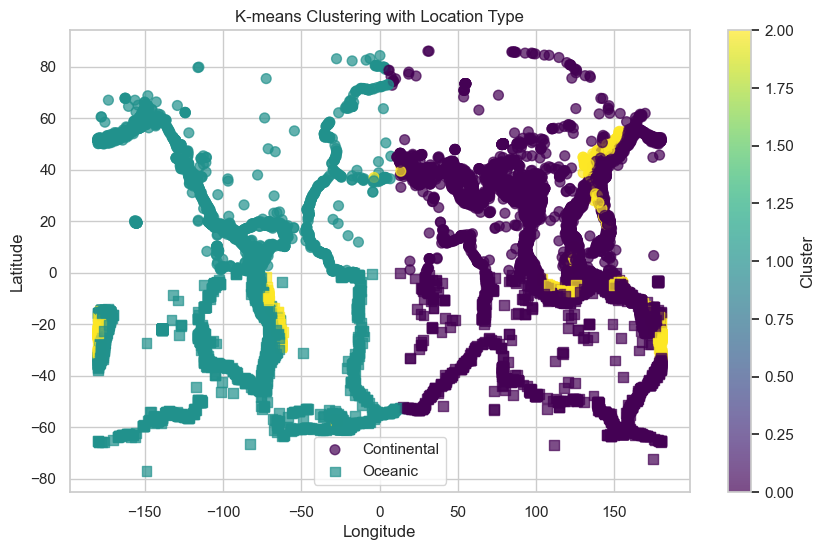

In [206]:
# Add jitter to the data points within each cluster for better visibility
jitter_amount = 0.005  # Adjust the jitter amount as needed

# Visualize the clusters, using shapes to represent different location types and marker styles
plt.figure(figsize=(10, 6))

# Define marker styles for each location type
marker_styles = ['o', 's']  # 'o' for circle (continental), 's' for square (oceanic)

for location_type, marker_style in zip(location_types, marker_styles):
    subset = earthquake_data[earthquake_data['Location Type'] == location_type].copy()
    
    # Add jitter to Longitude and Latitude
    subset['Longitude_jittered'] = subset['Longitude'] + np.random.uniform(-jitter_amount, jitter_amount, len(subset))
    subset['Latitude_jittered'] = subset['Latitude'] + np.random.uniform(-jitter_amount, jitter_amount, len(subset))
    
    plt.scatter(
        subset['Longitude_jittered'],
        subset['Latitude_jittered'],
        c=subset['Cluster'],
        cmap='viridis',
        s=50,  # Increase marker size for better visibility
        alpha=0.7,  # Adjust transparency for better visibility
        marker=marker_style,
        label=location_type
    )

# Add colorbar for 'Cluster'
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

plt.title('K-means Clustering with Location Type')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()  # Show legend with location types
plt.show()

In [221]:
# Assuming your earthquake_data DataFrame has columns 'Location Type', 'Earthquake Type', 'Latitude', 'Longitude', 'Date'

# Remove timezone information (make the datetime column naive)
earthquake_data['Date'] = earthquake_data['Date'].apply(lambda x: x.replace(tzinfo=None))

# Convert the 'Date' column to datetime format
earthquake_data['Date'] = pd.to_datetime(earthquake_data['Date'])


In [226]:
# Create a graph
G = nx.Graph()

In [228]:
# Iterate through each row in the dataframe
for idx, row in earthquake_data.iterrows():
    # Add node for each earthquake
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], date=row['Date'])

In [229]:
# Iterate through each pair of nodes to check for the same day or month
for u, data_u in G.nodes(data=True):
    for v, data_v in G.nodes(data=True):
        if u != v and (data_u['date'].day == data_v['date'].day or data_u['date'].month == data_v['date'].month):
            # Add edge if the earthquakes occurred on the same day or in the same month
            G.add_edge(u, v)

In [230]:
# Network Analysis Techniques
degree_centrality = nx.degree_centrality(G)

In [231]:
# Set a threshold for degree centrality to filter nodes
threshold = 0.1
filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality > threshold]
filtered_G = G.subgraph(filtered_nodes)

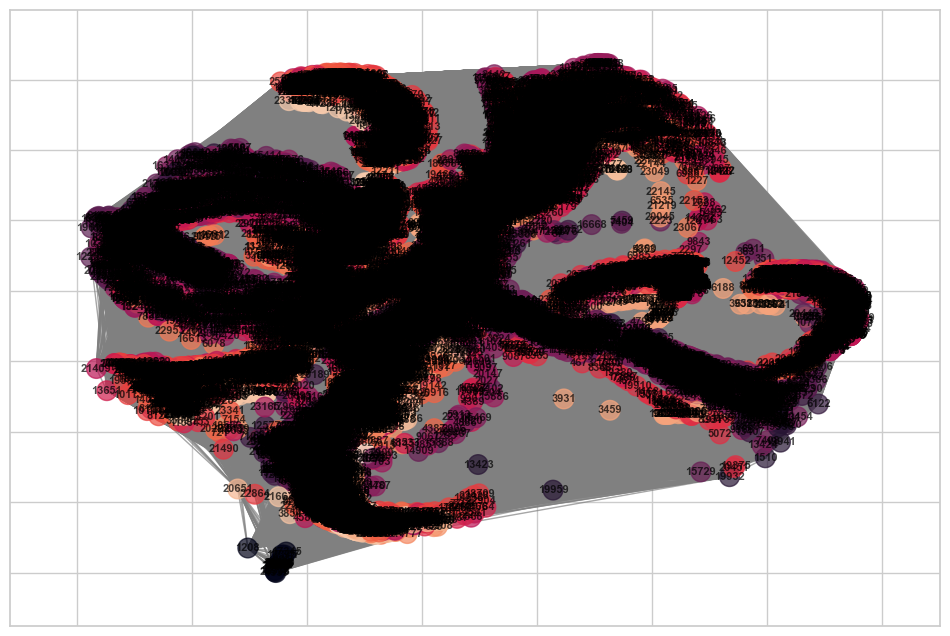

In [232]:
# Improved Network Visualization
plt.figure(figsize=(12, 8))

# Use a different layout algorithm for better positioning
pos = nx.spring_layout(filtered_G, seed=42)

# Customize node colors and edge colors
node_color = [degree_centrality[node] for node in filtered_G.nodes()]
edge_color = 'gray'

# Draw the network with improved styling
nx.draw_networkx(filtered_G, pos=pos, with_labels=True, node_size=200, node_color=node_color, edge_color=edge_color,
                 font_size=8, font_color='black', font_weight='bold', alpha=0.7)

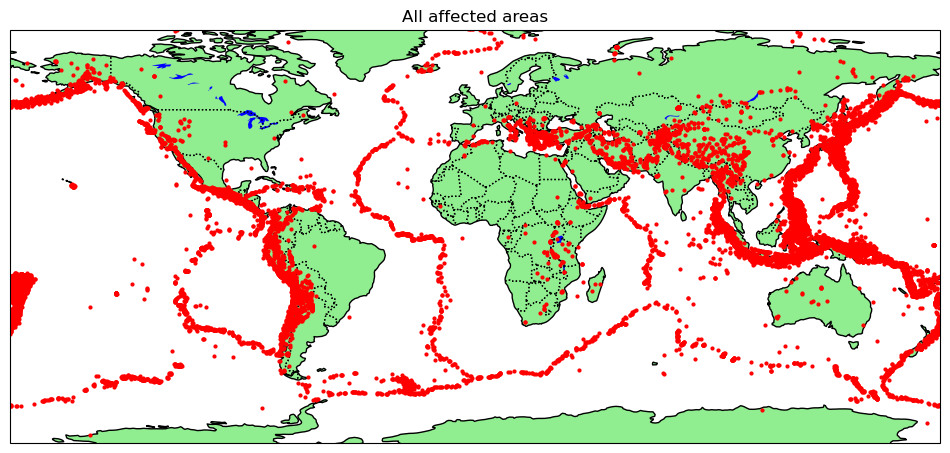

In [27]:
# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map
ax.set_extent([-180, 180, -80, 80])

# Convert longitudes and latitudes to NumPy arrays
longitudes = earthquake_data["Longitude"].astype(float)
latitudes = earthquake_data["Latitude"].astype(float)

# Convert longitudes and latitudes to map coordinates
xy = ax.projection.transform_points(ccrs.PlateCarree(), longitudes, latitudes)
x, y = xy[:, 0], xy[:, 1]

# Plot your data points
ax.plot(x, y, 'o', markersize=2, color='red')

# Draw map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgreen')
ax.add_feature(cfeature.LAKES, facecolor='blue')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Show the map
plt.title("All affected areas")
plt.show()

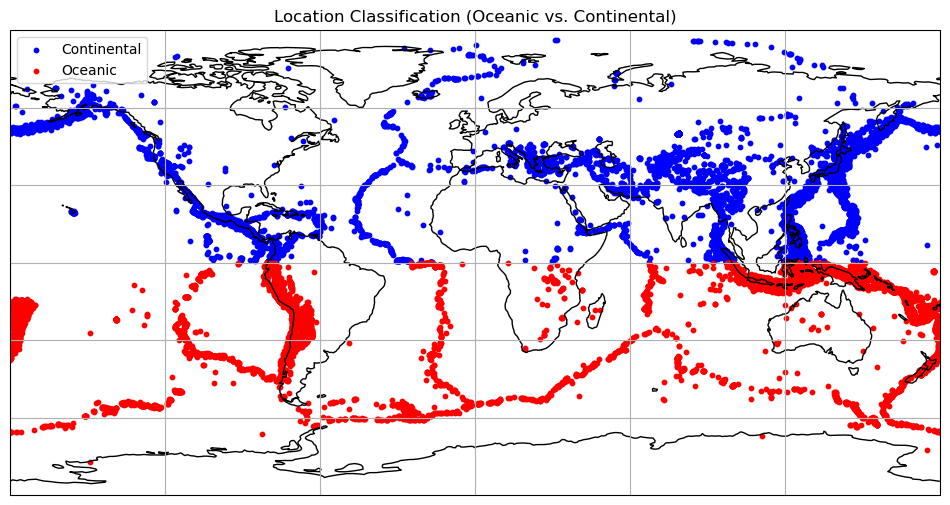

In [28]:
# Create a map visualization
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])

# Plot earthquake locations with different colors based on Location Type
for location_type, group in earthquake_data.groupby('Location Type'):
    color = 'blue' if location_type == 'Continental' else 'red'  # Adjust colors as needed
    ax.scatter(group['Longitude'], group['Latitude'], label=location_type, color=color, s=10)

# Add legend and title
ax.legend()
ax.set_title('Location Classification (Oceanic vs. Continental)')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

plt.show()

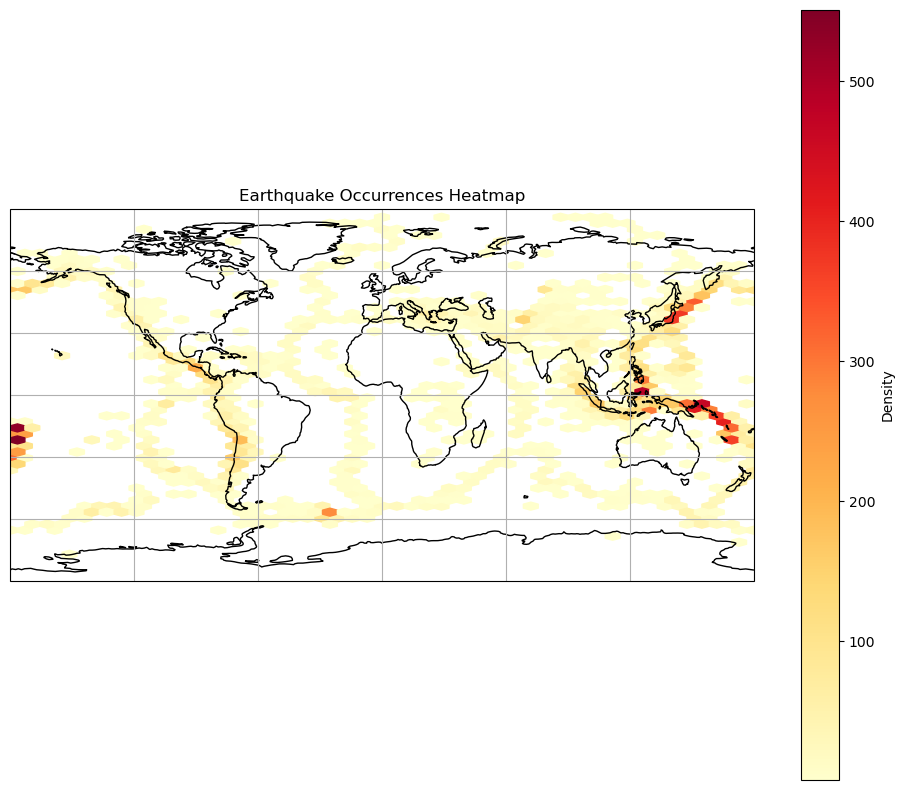

In [29]:
# Create a map visualization with a heatmap
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])

# Plot a heatmap of earthquake occurrences using hexbin
hb = ax.hexbin(
    earthquake_data['Longitude'],
    earthquake_data['Latitude'],
    gridsize=50,  # Adjust gridsize as needed
    cmap='YlOrRd',  # Choose a colormap
    mincnt=1,  # Minimum count for a bin to be colored
)

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Add a colorbar
cbar = plt.colorbar(hb, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Density')

# Add a title
ax.set_title('Earthquake Occurrences Heatmap')

plt.show()

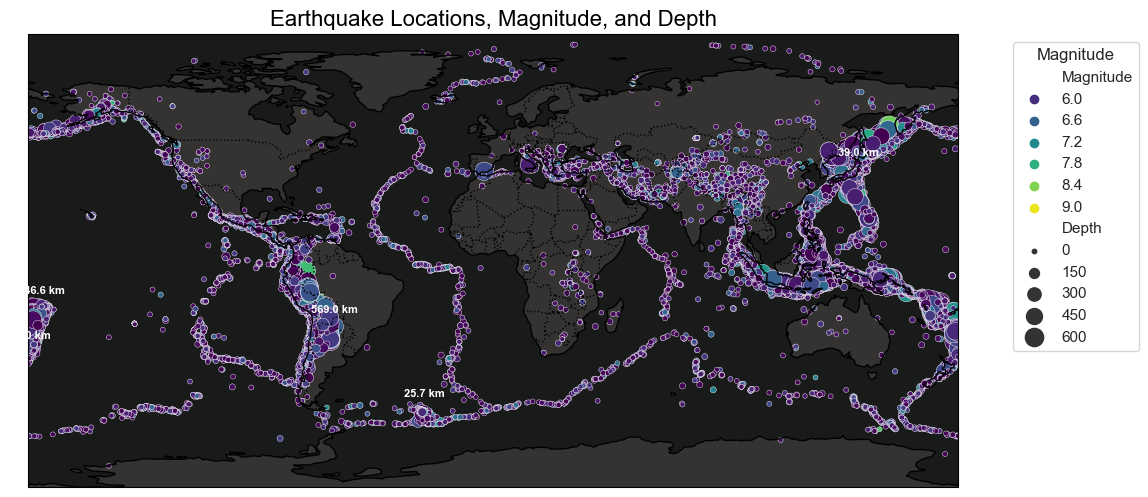

In [30]:
# Define the desired RGB values for colors
ocean_color = (25/255, 26/255, 26/255)  # RGB for #191a1a
land_color = (52/255, 51/255, 50/255)   # RGB for #343332

# Filter out missing values in relevant columns
filtered_earthquake_data = earthquake_data.dropna(subset=['Longitude', 'Latitude', 'Magnitude', 'Time of Day or Season'])

# Set up the plot with Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
sns.set(style="whitegrid")

# Scatter plot with color-coded magnitude and size-coded depth
scatter = sns.scatterplot(
    x='Longitude', y='Latitude',
    hue='Magnitude', size='Depth',
    sizes=(10, 200), palette='viridis',
    data=filtered_earthquake_data,
    ax=ax
)

# Customize facecolors of land and ocean features
ax.add_feature(cfeature.LAND, facecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color)

# Draw map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Annotate a subset of points with their depth values
depth_annotation_subset = filtered_earthquake_data.sample(n=5)  # Change 5 to the desired number
for idx, row in depth_annotation_subset.iterrows():
    ax.annotate(f"{row['Depth']} km", (row['Longitude'], row['Latitude']),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='white', fontweight='bold')

# Adjust plot aesthetics
plt.title('Earthquake Locations, Magnitude, and Depth', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Magnitude', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

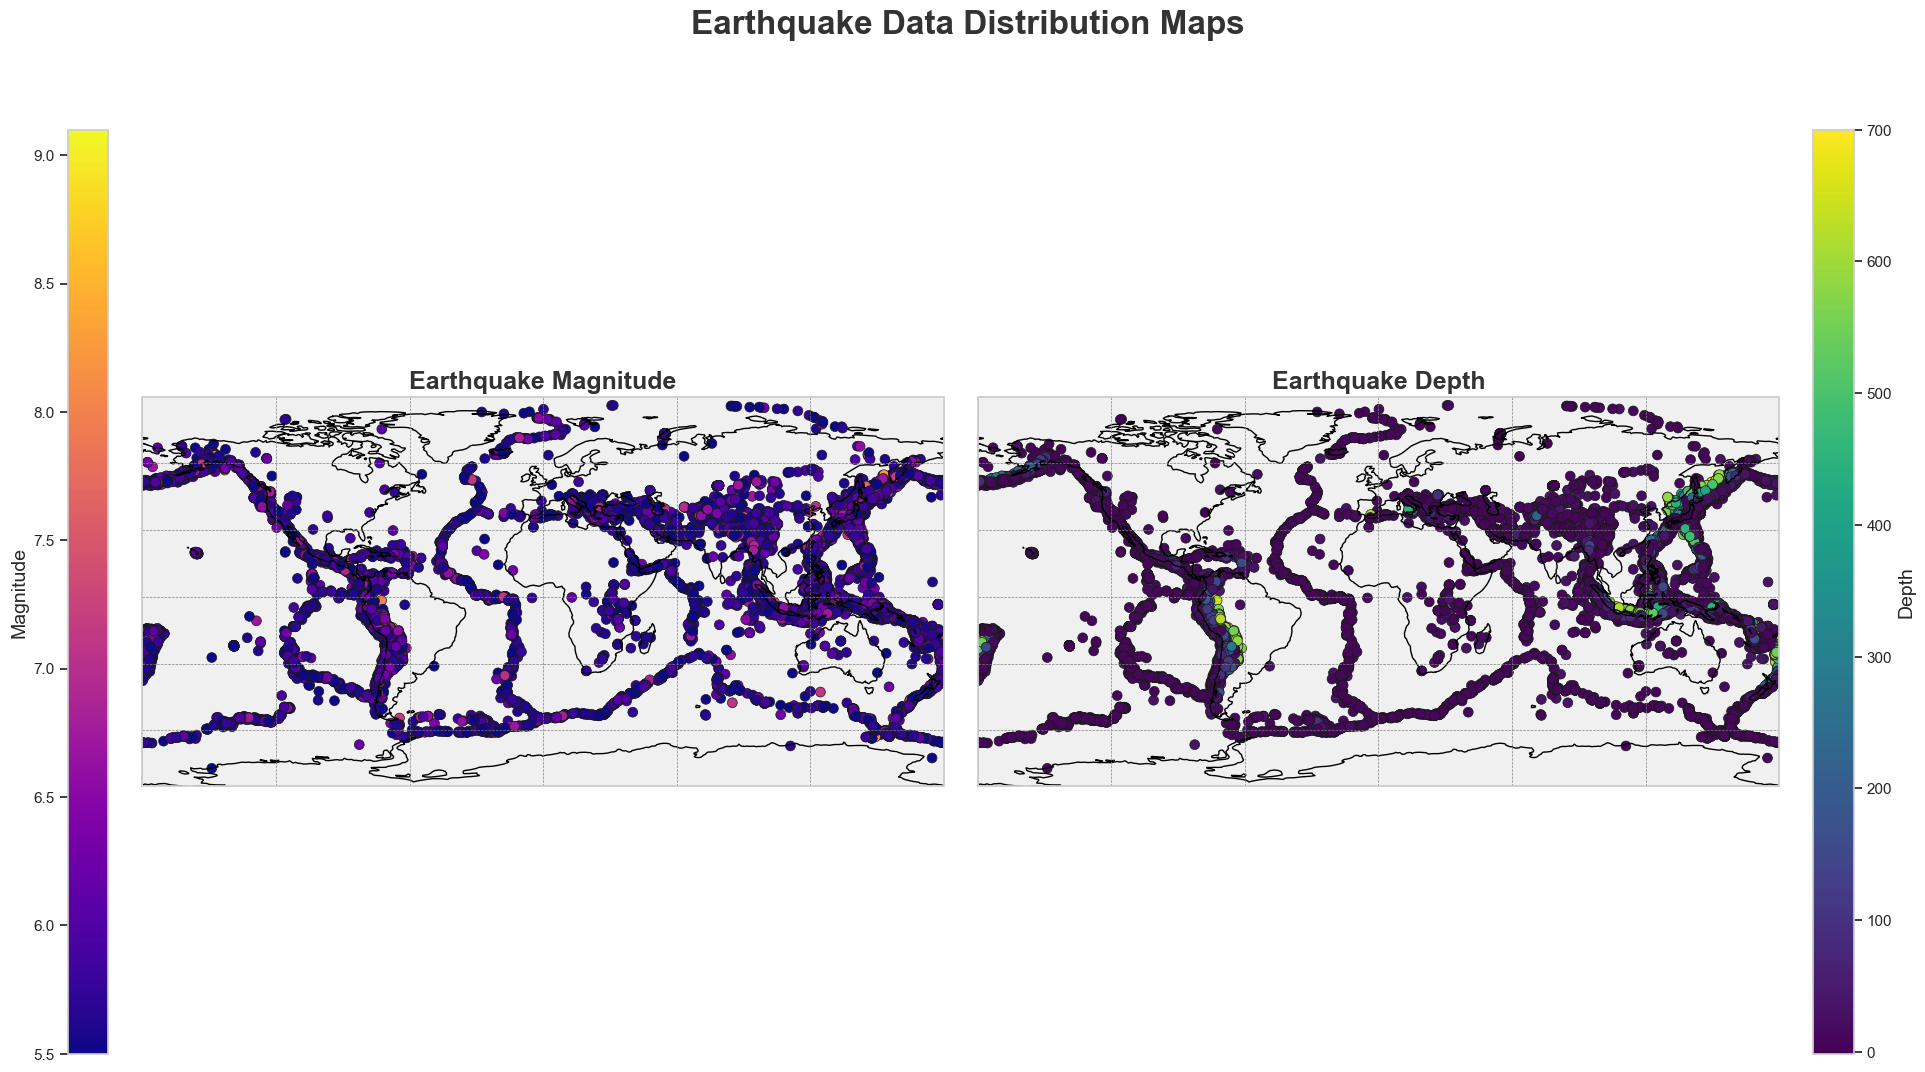

In [31]:

# Set up the plot with Cartopy
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(1, 5, width_ratios=[0.05, 1, 1, 0.05, 0.05], wspace=0.1)

# Scatter plot with color-coded magnitude
ax_magnitude = plt.subplot(gs[1], projection=ccrs.PlateCarree())
scatter_magnitude = ax_magnitude.scatter(
    filtered_earthquake_data['Longitude'], filtered_earthquake_data['Latitude'],
    c=filtered_earthquake_data['Magnitude'], s=50, cmap='plasma', edgecolors='k', linewidth=0.5,
    transform=ccrs.PlateCarree()
)
# Customize the magnitude scatter plot subplot
ax_magnitude.coastlines() # Add coastlines for geographic reference
ax_magnitude.gridlines(color='gray', linestyle='--', linewidth=0.5) # Add gridlines for geographic reference
ax_magnitude.set_facecolor('#f0f0f0')  # Light gray background
ax_magnitude.set_title('Earthquake Magnitude', fontsize=18, fontweight='bold', color='#333333')
ax_magnitude.set_xlabel('Longitude', fontsize=14)
ax_magnitude.set_ylabel('Latitude', fontsize=14)

# Add colorbar on the left for magnitude
cax_magnitude = plt.subplot(gs[0])
cbar_magnitude = plt.colorbar(scatter_magnitude, cax=cax_magnitude, orientation='vertical')
cbar_magnitude.set_label('Magnitude', fontsize=14)

# Move the colorbar to the left side
cax_magnitude.yaxis.set_ticks_position('left')
cax_magnitude.yaxis.set_label_position('left')

# Scatter plot with color-coded depth
ax_depth = plt.subplot(gs[2], projection=ccrs.PlateCarree())
scatter_depth = ax_depth.scatter(
    filtered_earthquake_data['Longitude'], filtered_earthquake_data['Latitude'],
    c=filtered_earthquake_data['Depth'], s=50, cmap='viridis', edgecolors='k', linewidth=0.5,
    transform=ccrs.PlateCarree()
)
# Customize the depth scatter plot subplot
ax_depth.coastlines() # Add coastlines for geographic reference
ax_depth.gridlines(color='gray', linestyle='--', linewidth=0.5) # Add gridlines for geographic reference
ax_depth.set_facecolor('#f0f0f0')  # Light gray background
ax_depth.set_title('Earthquake Depth', fontsize=18, fontweight='bold', color='#333333')
ax_depth.set_xlabel('Longitude', fontsize=14)
ax_depth.set_ylabel('Latitude', fontsize=14)

# Add colorbar on the right for depth
cax_depth = plt.subplot(gs[3])
cbar_depth = plt.colorbar(scatter_depth, cax=cax_depth, orientation='vertical')
cbar_depth.set_label('Depth', fontsize=14)

# Overall title for the entire set of maps
fig.suptitle('Earthquake Data Distribution Maps', fontsize=24, fontweight='bold', color='#333333')

# Show the plot
plt.show()

In [32]:
# Filter out missing values in relevant columns
filtered_earthquake_data = earthquake_data.dropna(subset=['Longitude', 'Latitude', 'Magnitude', 'Time of Day or Season'])

# Create an interactive map using Folium
map_center = [filtered_earthquake_data['Latitude'].mean(), filtered_earthquake_data['Longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=3, control_scale=True)

# Create a MarkerCluster for better performance with a large number of markers
marker_cluster = MarkerCluster().add_to(mymap)

# Add earthquake data as markers to the map
for idx, row in filtered_earthquake_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Magnitude'] * 2,
        color=sns.color_palette("viridis", as_cmap=True)(row['Magnitude'] / 10),
        fill=True,
        fill_color=sns.color_palette("viridis", as_cmap=True)(row['Magnitude'] / 10),
        fill_opacity=0.7,
        tooltip=f"Magnitude: {row['Magnitude']}, Depth: {row['Depth']}",
    ).add_to(marker_cluster)

# Display the map
mymap.save('earthquake_map.html')

In [33]:
# Display the map in the notebook
IFrame(src='earthquake_map.html', width=800, height=700)

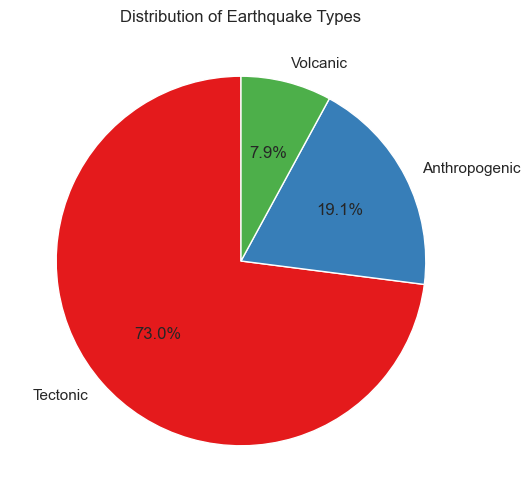

In [233]:
# Assuming earthquake_data has a column 'Earthquake Type'
# Count the occurrences of each earthquake type
earthquake_type_counts = earthquake_data['Earthquake Type'].value_counts()

# Set the style of Seaborn
sns.set(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(10, 6))
pie_chart = plt.pie(
    earthquake_type_counts,
    labels=earthquake_type_counts.index,
    autopct='%1.1f%%',  # Display percentage on each slice
    startangle=90,  # Start the pie chart at 90 degrees (top of the circle)
    colors=sns.color_palette('Set1')  # You can choose a different color palette
)

# Set plot title
plt.title('Distribution of Earthquake Types')

# Show the plot
plt.show()

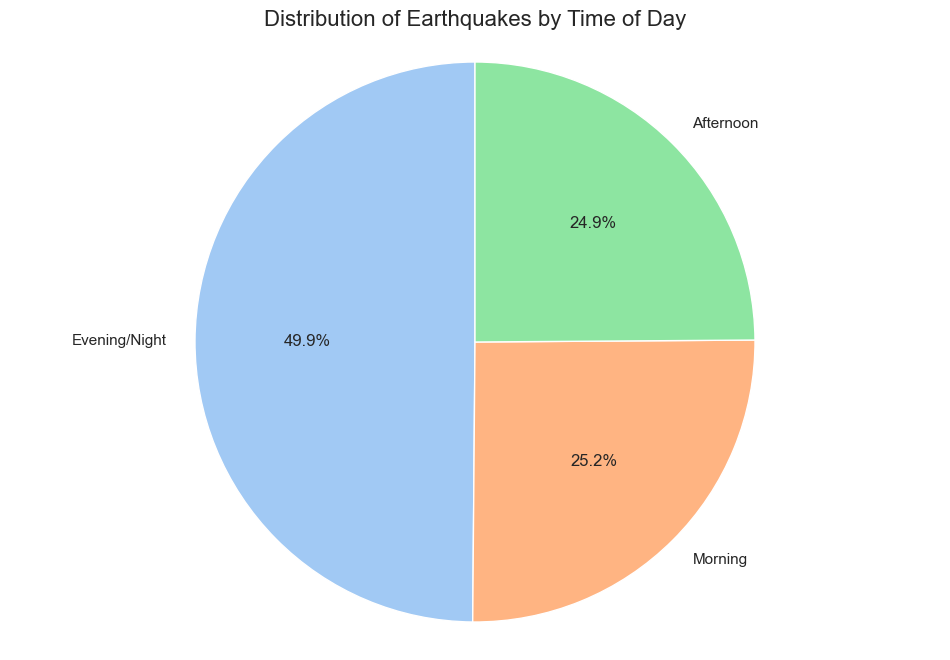

In [235]:
# Assuming earthquake_data has a column 'Time of Day or Season'
# Count the occurrences of each time category
time_counts = earthquake_data['Time of Day or Season'].value_counts()

# Set a custom color palette
colors = sns.color_palette("pastel")

# Plot the pie chart with style
plt.figure(figsize=(12, 8))
pie_chart = plt.pie(time_counts, labels=time_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Earthquakes by Time of Day', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()